In [1]:
# Import and GPU Support
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import time

from B_data import create_residual_data, create_IC_data, initial_u,exact_u, create_BC_data, create_RH_data,create_RH_data_endt,Move_Time_1D,burgersDdt_godunov,godunov,exact_u_err
from B_Plotting import Burgers_plot, loss_plot 
from scipy.integrate import solve_ivp

# Full PINN
from B_PINN import NN
from B_PINN_train import pinn_train

# Burgers GPT-PINN
from B_GPT_activation import P
from B_GPT_PINNs import GPT
from B_GPT_train import gpt_train

torch.set_default_dtype(torch.float)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {device}")
if torch.cuda.is_available():
    print(f"Current Device Name: {torch.cuda.get_device_name()}")

Current Device: cuda
Current Device Name: NVIDIA A100-SXM4-40GB


In [2]:
# Training Parameter Set
number_of_parameters = 2
nu1_training = np.linspace(0.75, 1.25, number_of_parameters)
nu2_training  = np.linspace(0.1, 0.4, number_of_parameters)

nu_training = []
for i in range(nu1_training.shape[0]):
    for j in range(nu2_training.shape[0]):
        nu_training.append([nu1_training[i],nu2_training[j]])
nu_training = np.array(nu_training)

nu_pinn_train = [1.0,0.0]
number_of_neurons = 1
P_list = np.ones(number_of_neurons, dtype=object) 

In [3]:
# Domain and Data
Xi, Xf         = 0.0, 1.0
Ti, Tf         =  0.0, 1.0
Nx_train, Nt_train =  101, 201
Nx_test, Nt_test = 101, 201
IC_pts, IC_simple = 100, 100
BC_pts =  100
N_RH = IC_pts
dx = 0.001
dt = 0.0002

residual_data = create_residual_data(Xi, Xf, Ti, Tf, Nx_train, Nt_train, Nx_test, Nt_test, dx,dt)
xt_resid      = residual_data[0].to(device)
f_hat         = residual_data[1].to(device)
xt_test       = residual_data[2].to(device)
xt_RHL      = residual_data[3].to(device)
xt_RHR      = residual_data[4].to(device)
xt_RHt         = residual_data[5].to(device)
xt_RHtL       = residual_data[6].to(device)

IC_x_test     = xt_test[0:Nx_test,:1].squeeze().cpu()
IC_t_test     = xt_test[0:Nx_test*Nt_test:Nx_test,1:].squeeze().cpu()

Nx_test0, Nt_test0 = 1001, 2001
xt_test0 = create_residual_data(Xi, Xf, Ti, Tf, Nx_train, Nt_train, Nx_test0, Nt_test0, dx,dt)[2].to(device)
IC_x_test0     = xt_test0[0:Nx_test0,:1].squeeze().cpu()
IC_t_test0     = xt_test0[0:Nx_test0*Nt_test0:Nx_test0,1:].squeeze().cpu()   

BC_data = create_BC_data(Xi, Xf, Ti, Tf, BC_pts)
BC1     = BC_data[0].to(device)
BC2     = BC_data[1].to(device)

#xt_RH_data = create_RH_data(Xi, Xf, Ti, Tf, IC_pts, N_RH,dx)
#xt_RH = xt_RH_data[0].to(device)
#xt_RHL = xt_RH_data[1].to(device)

In [4]:
# Setting PINN and TGPT-PINN
# Setting PINN and TGPT-PINN
layers_pinn = np.array([2, 30, 30, 30, 30, 30, 1])

lr_pinn     = 0.001
epochs_pinn = 60000
tol_pinn    = 1e-5

pinn_train_times = np.ones(number_of_neurons)

###############################################################################
################################ Training Loop ################################
###############################################################################

In [5]:
import pickle
P_name=f"IFNN_shock3.pkl"
with open(P_name, 'rb') as f:
    P_list = pickle.load(f)

[0.75 0.1 ] stopped at epoch: 0 | gpt_loss: 0.4352359175682068,rMAE: [0.3659288138173758], rRMSE:[0.7187126848821233], 0.025850124657154083, 0.040938567370176315, 9.566160308338567e-09, 1.2101540472833627e-12
[0.75 0.1 ] stopped at epoch: 500 | gpt_loss: 0.0007066683028824627,rMAE: 0.03069630411432173, rRMSE:0.18697657058273442, 0.0002472548221703619, 6.601882205359288e-07, 7.930004244371958e-07, 4.4488158891908824e-05
[0.75 0.1 ] stopped at epoch: 1000 | gpt_loss: 0.0007066718535497785,rMAE: 0.03069685791185755, rRMSE:0.1869793077583383, 0.0002472586347721517, 6.601580935239326e-07, 7.930072456474591e-07, 4.4488158891908824e-05
[0.75 0.1 ] stopped at epoch: 1500 | gpt_loss: 0.00070666748797521,rMAE: 0.03069628645582572, rRMSE:0.18697646801148537, 0.0002472531341481954, 6.602223265872453e-07, 7.930553351798153e-07, 4.4488158891908824e-05
[0.75 0.1 ] stopped at epoch: 2000 | gpt_loss: 0.000911797396838665,rMAE: 0.022197049658946012, rRMSE:0.09192544181797782, 0.00024719411158002913, 2.9

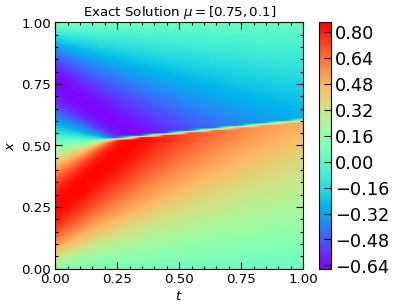

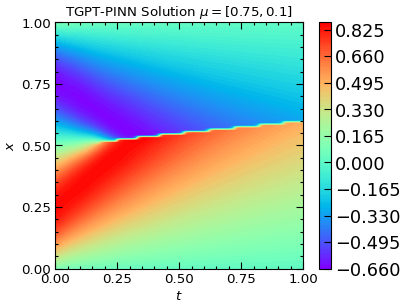

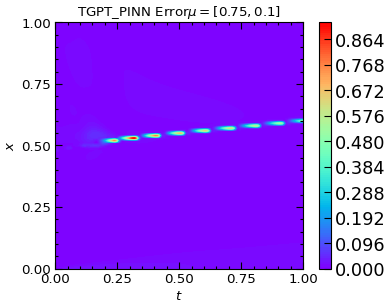

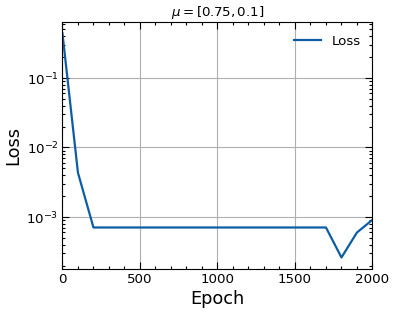

GPT-PINN at [0.75 0.1 ] with the Loss=0.000911797396838665, rMAE = 0.022197049658946012, rRMSE = 0.09192544181797782


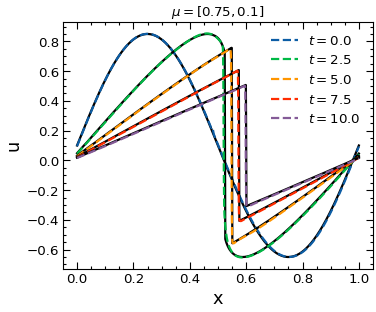

[0.75 0.4 ] stopped at epoch: 0 | gpt_loss: 2.0861382484436035,rMAE: [0.868565203218479], rRMSE:[1.1166726170899548], 0.17673885822296143, 0.19093991816043854, 9.566160308338567e-09, 1.2101540472833627e-12
[0.75 0.4 ] stopped at epoch: 500 | gpt_loss: 0.002319523598998785,rMAE: 0.038173300948695546, rRMSE:0.1689307427105203, 0.0005021968390792608, 3.602576907724142e-05, 0.00011239400191698223, 3.3312884625047445e-05
[0.75 0.4 ] stopped at epoch: 1000 | gpt_loss: 0.0023195291869342327,rMAE: 0.038173549370074805, rRMSE:0.16893131685355411, 0.0005021970137022436, 3.60258090950083e-05, 0.00011239450395805761, 3.3312884625047445e-05
[0.75 0.4 ] stopped at epoch: 1500 | gpt_loss: 0.002319535706192255,rMAE: 0.03817320125222674, rRMSE:0.16893028240983812, 0.0005022009718231857, 3.6026227462571114e-05, 0.00011239433661103249, 3.3312884625047445e-05
[0.75 0.4 ] stopped at epoch: 2000 | gpt_loss: 0.002319557825103402,rMAE: 0.03817073141107714, rRMSE:0.1689216961933628, 0.0005022595869377255, 3.60

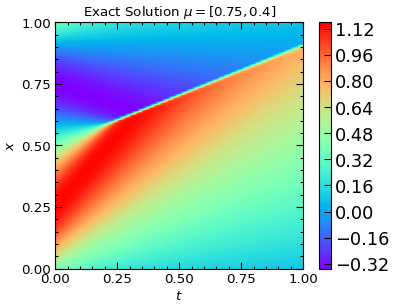

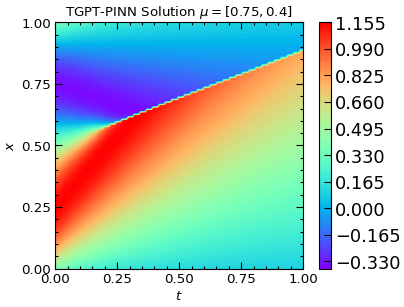

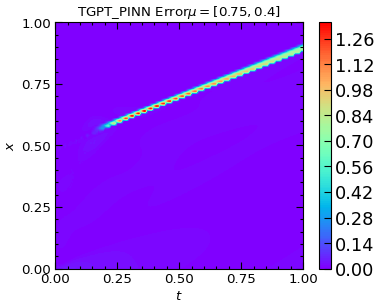

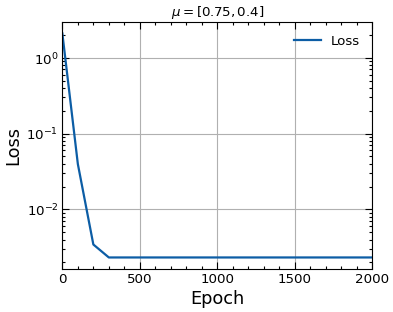

GPT-PINN at [0.75 0.4 ] with the Loss=0.002319557825103402, rMAE = 0.03817073141107714, rRMSE = 0.1689216961933628


/dssg/home/acct-matxzl/matxzl/Yajie/GPT-PINN2/0513_characteristic_v1/shock1_0412/shock3_0518/B_data.py:138: RuntimeWarning: overflow encountered in divide
  dudt = (fu_interface - np.roll(fu_interface, -1)) / (1/u.size)


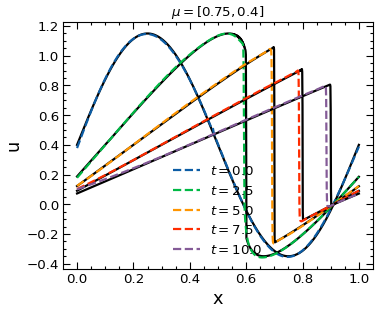

[1.25 0.1 ] stopped at epoch: 0 | gpt_loss: 0.4346519708633423,rMAE: [0.26654678874414434], rRMSE:[0.5716951786319594], 0.025277739390730858, 0.04093741253018379, 9.566160308338567e-09, 1.2101540472833627e-12
[1.25 0.1 ] stopped at epoch: 500 | gpt_loss: 0.0014920461690053344,rMAE: 0.025067979185432666, rRMSE:0.14289284432172167, 0.0011922726407647133, 1.1732191751434584e-06, 1.2881360817118548e-05, 1.5922780221444555e-05
[1.25 0.1 ] stopped at epoch: 1000 | gpt_loss: 0.0011895161587744951,rMAE: 0.02652241558761674, rRMSE:0.15992077191827667, 0.0010409248061478138, 2.218825557065429e-06, 1.2640286513487808e-05, 2.681393822256961e-11
[1.25 0.1 ] stopped at epoch: 1500 | gpt_loss: 0.0012591071426868439,rMAE: 0.030167112684259048, rRMSE:0.17796293002563482, 0.0011283090570941567, 2.029941470027552e-06, 1.1049846762034576e-05, 1.9997689268413943e-11
[1.25 0.1 ] stopped at epoch: 2000 | gpt_loss: 0.0014817408518865705,rMAE: 0.032206006706124835, rRMSE:0.1858914381527764, 0.00117976462934166

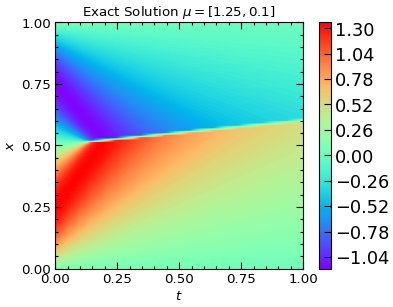

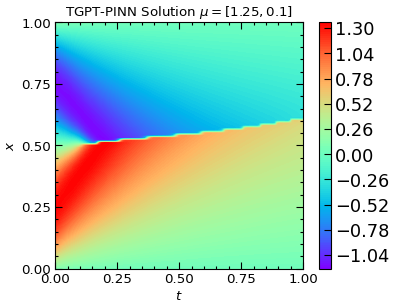

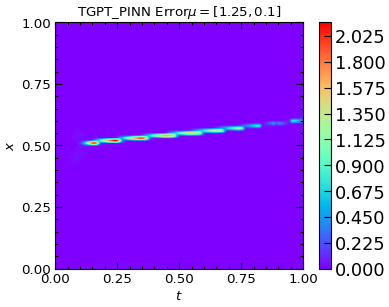

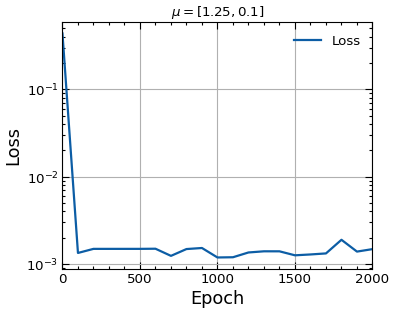

GPT-PINN at [1.25 0.1 ] with the Loss=0.0014817408518865705, rMAE = 0.032206006706124835, rRMSE = 0.1858914381527764


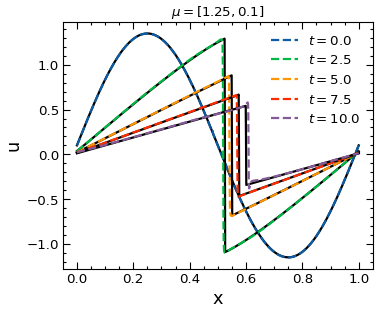

[1.25 0.4 ] stopped at epoch: 0 | gpt_loss: 2.0837979316711426,rMAE: [0.7287366685226848], rRMSE:[0.986358306419847], 0.17441034317016602, 0.19093875586986542, 9.566160308338567e-09, 1.2101540472833627e-12
[1.25 0.4 ] stopped at epoch: 500 | gpt_loss: 0.011718600988388062,rMAE: 0.04715283734063173, rRMSE:0.20768439783532702, 0.004395369440317154, 7.595968781970441e-05, 0.0004644068540073931, 0.00019195667118765414
[1.25 0.4 ] stopped at epoch: 1000 | gpt_loss: 0.01002829521894455,rMAE: 0.04661863982786482, rRMSE:0.20495816637617642, 0.004477113485336304, 7.825739157851785e-05, 0.0004614919307641685, 1.536890158604365e-05
[1.25 0.4 ] stopped at epoch: 1500 | gpt_loss: 0.010033734142780304,rMAE: 0.046647234706202065, rRMSE:0.2048685415014106, 0.004481461830437183, 7.855573494452983e-05, 0.0004613026394508779, 1.5368896129075438e-05
[1.25 0.4 ] stopped at epoch: 2000 | gpt_loss: 0.009877040982246399,rMAE: 0.04659447897314892, rRMSE:0.20468888470973334, 0.004475634079426527, 7.888912659836

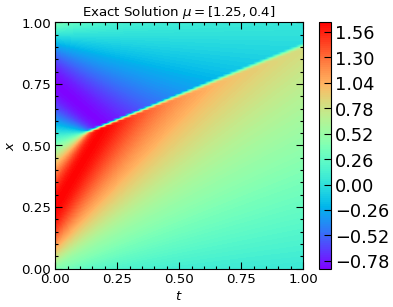

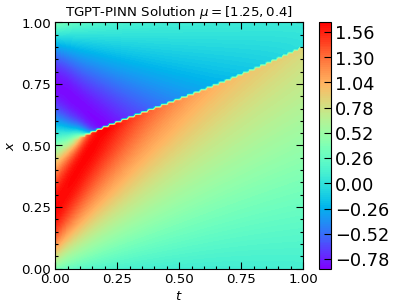

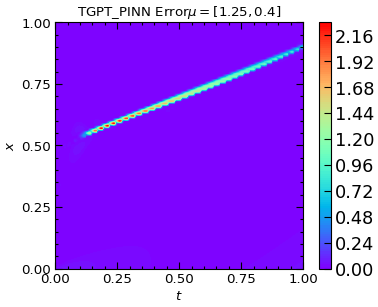

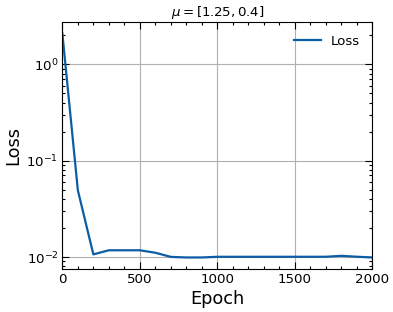

GPT-PINN at [1.25 0.4 ] with the Loss=0.009877040982246399, rMAE = 0.04659447897314892, rRMSE = 0.20468888470973334


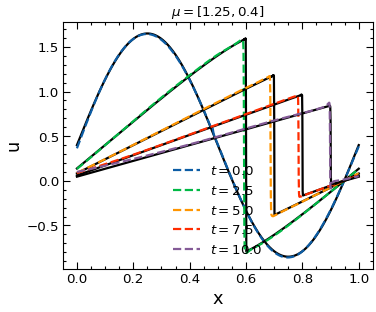

Largest Loss: 0.009877040982246399 at [1.25 0.4 ]
Largest L1: 0.04659447897314892 at [1.25 0.4 ]
Largest L2: 0.20468888470973334 at [1.25 0.4 ]
Loss:[0.000911797396838665, 0.002319557825103402, 0.0014817408518865705, 0.009877040982246399]
L1:[0.022197049658946012, 0.03817073141107714, 0.032206006706124835, 0.04659447897314892]
L2:[0.09192544181797782, 0.1689216961933628, 0.1858914381527764, 0.20468888470973334]


In [6]:
i=0
nu_pinn_train   =1.0    
lr_gpt          = 0.005
epochs_gpt      = 2000
tol_gpt         = 1e-5
############################ GPT-PINN Training ############################
layers_gpt = np.array([2, i+1, 1])
c_initial  = torch.full((1,i+1), 1/(i+1))
nu_loss = []
L1_err  = []
L2_err  = []
Cor_err =  []

gpt_train_time_1 = time.perf_counter()
for nu in nu_training:
    IC_u_test = initial_u(nu,IC_x_test)
    God_sol=solve_ivp(burgersDdt_godunov, t_span=(0, Tf), y0=IC_u_test.cpu(), t_eval=IC_t_test)
    Exact_y0 = torch.from_numpy(God_sol.y.T.reshape(xt_test.shape[0],1)).to(device)

    IC_data = create_IC_data(nu, Xi, Xf, Ti, Tf, IC_pts, IC_simple)
    IC_xt     = IC_data[0].to(device)
    IC_u      = IC_data[1].to(device)

    #print((P_list[0]).linears[0].bias)
    GPT_PINN = GPT(nu, layers_gpt, P_list[0:i+1], c_initial,xt_resid, f_hat, Exact_y0, xt_test, IC_xt, IC_u,  BC1, BC2,xt_RHL,xt_RHR,xt_RHt,xt_RHtL,Nx_train,Nt_train,dt).to(device)

    gpt_losses = gpt_train(GPT_PINN, nu, xt_resid, f_hat, Exact_y0, xt_test, IC_xt, IC_u, BC1, BC2, epochs_gpt, lr_gpt, tol_gpt)

    nu_loss.append(gpt_losses[0].item())
    L1_err.append(gpt_losses[3][-1])
    L2_err.append(gpt_losses[4][-1])


    Burgers_plot(xt_test, Exact_y0, Nx_test,Nt_test,title=fr"Exact Solution $\mu=[{nu[0]},{nu[1]}]$")
    Burgers_plot(xt_test, GPT_PINN.forward(xt_test), Nx_test,Nt_test,title=fr"TGPT-PINN Solution $\mu=[{nu[0]},{nu[1]}]$")
    Burgers_plot(xt_test, abs(GPT_PINN.forward(xt_test)-Exact_y0), Nx_test,Nt_test,title=fr"TGPT_PINN Error$\mu=[{nu[0]},{nu[1]}]$")

    plt.figure(dpi=80, figsize=(5,4))    
    plt.plot(gpt_losses[1], gpt_losses[2], label="Loss")
    #plt.plot(gpt_losses[1], gpt_losses[3], label="L1 error")
    #plt.plot(gpt_losses[1], gpt_losses[4], label="L2 error")
    #plt.plot(gpt_losses[1], gpt_losses[5], label="Loss_implict")
    #plt.plot(gpt_losses[1], gpt_losses[8], label="Loss_Res")
    #plt.plot(gpt_losses[1], gpt_losses[6], label="Loss_IC")
    #plt.plot(gpt_losses[1], gpt_losses[7], label="Loss_BC")

    plt.xlabel("Epoch",     fontsize=16)
    plt.ylabel("Loss", fontsize=16)

    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    
    plt.grid(True)
    plt.xlim(0,max(gpt_losses[1]))
    plt.yscale('log')
    plt.title(fr"$\mu=[{nu[0]},{nu[1]}]$", fontsize=12)
    plt.legend(fontsize = 12)#
    plt.show()

    #err =exact_u_err(Exact_y0,GPT_PINN(xt_test),xt_test,nu)[1]
    #Cor_err.append(err.item())
    #print(f"GPT-PINN at {nu} with the Loss={gpt_losses[0].item()}, rMAE = {gpt_losses[3][-1]}, rRMSE = {gpt_losses[4][-1]} and Cor error = {err.item()}")
    print(f"GPT-PINN at {nu} with the Loss={gpt_losses[0].item()}, rMAE = {gpt_losses[3][-1]}, rRMSE = {gpt_losses[4][-1]}")

    IC_u_test0 = initial_u(nu,IC_x_test0)
    God_sol0=solve_ivp(burgersDdt_godunov, t_span=(0, Tf), y0=IC_u_test0.cpu(), t_eval=IC_t_test0)
    Exact_y0 = torch.from_numpy(God_sol0.y.T.reshape(xt_test0.shape[0],1)).to(device)  
    PINN_y0 = GPT_PINN.forward(xt_test0)
    plt.figure(dpi=80, figsize=(5,4))#dpi=150, figsize=(10,8)
    for ind in range(1, Nt_test0+1,500):
        plt.plot(xt_test0[0:Nx_test0,0].detach().cpu(),Exact_y0[(ind-1)*Nx_test0:ind*Nx_test0,0].detach().cpu(),'k')
        #plt.scatter(xt_test[0:Nx_test,0].detach().cpu(),PINN(xt_test)[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),s=20,label=fr"$t={round((ind-1)*(Tf-Ti)/(Nt_test-1),3)}$")
        plt.plot(xt_test0[0:Nx_test0,0].detach().cpu(),PINN_y0[(ind-1)*Nx_test0:ind*Nx_test0,0].detach().cpu(),'--',label=fr"$t={round((ind-1)*(Tf-Ti)/(Nt_test-1),3)}$")
    plt.xlabel("x",     fontsize=16)
    plt.ylabel("u", fontsize=16)

    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.title(fr"$\mu=[{nu[0]},{nu[1]}]$", fontsize=12)
    plt.legend(fontsize = 12)#
    plt.show()

        
print(f"Largest Loss: {max(nu_loss)} at {nu_training[nu_loss.index(max(nu_loss))]}")
print(f"Largest L1: {max(L1_err)} at {nu_training[L1_err.index(max(L1_err))]}")
print(f"Largest L2: {max(L2_err)} at {nu_training[L2_err.index(max(L2_err))]}") 

print(f"Loss:{nu_loss}")
print(f"L1:{L1_err}")
print(f"L2:{L2_err}")